In [ ]:
!pip install transformers rouge-score scikit-learn nltk torch --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Percobaan/indonesia_dataset.csv')
df = df.dropna(subset=['summary', 'text'])

Mounted at /content/drive


In [ ]:
# Setup IndoBERT
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1").to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [ ]:
# Embedding cache
embedding_cache = {}
def embed_text(text):
    if text in embedding_cache:
        return embedding_cache[text]
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    emb = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    embedding_cache[text] = emb
    return emb

In [ ]:
# Summarization methods
def tfidf_summary(text, top_n=3):
    sentences = sent_tokenize(text)
    if len(sentences) <= top_n:
        return ' '.join(sentences)
    tfidf = TfidfVectorizer()
    matrix = tfidf.fit_transform(sentences)
    scores = matrix.sum(axis=1).A1
    top_idx = np.argsort(scores)[-top_n:]
    top_idx.sort()
    return ' '.join([sentences[i] for i in top_idx])

def indobert_summary(text, top_n=3):
    sentences = sent_tokenize(text)
    if len(sentences) <= top_n:
        return ' '.join(sentences)
    doc_embedding = embed_text(text)
    sent_embeddings = [embed_text(s) for s in sentences]
    similarities = [cosine_similarity([doc_embedding], [se])[0][0] for se in sent_embeddings]
    top_idx = np.argsort(similarities)[-top_n:]
    top_idx.sort()
    return ' '.join([sentences[i] for i in top_idx])

def gpt_like_summary(text, top_n=3):
    sentences = sent_tokenize(text)
    return ' '.join(sentences[:top_n])

In [ ]:
# Evaluator
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
def evaluate_summary(reference, generated):
    try:
        emb_ref = embed_text(reference)
        emb_gen = embed_text(generated)
        cos_sim = cosine_similarity([emb_ref], [emb_gen])[0][0]
        rouge_scores = scorer.score(reference, generated)
        return {
            'cosine': cos_sim,
            'rouge1': rouge_scores['rouge1'].fmeasure,
            'rouge2': rouge_scores['rouge2'].fmeasure,
            'rougeL': rouge_scores['rougeL'].fmeasure,
        }
    except:
        return {
            'cosine': 0.0, 'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0
        }

In [ ]:
# Evaluasi semua data
results = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    text = row['text']
    gold = row['summary']

    tfidf_sum = tfidf_summary(text)
    indobert_sum = indobert_summary(text)
    gpt_sum = gpt_like_summary(text)

    tfidf_eval = evaluate_summary(gold, tfidf_sum)
    indobert_eval = evaluate_summary(gold, indobert_sum)
    gpt_eval = evaluate_summary(gold, gpt_sum)

    # Simpan hanya jika semua ROUGE >= 0.5
    if (tfidf_eval['rouge1'] >= 0.5 and
        indobert_eval['rouge1'] >= 0.5 and
        gpt_eval['rouge1'] >= 0.5):

        results.append({
            'index': idx,
            'gold_summary': gold,
            'tfidf_summary': tfidf_sum,
            'indobert_summary': indobert_sum,
            'gpt_summary': gpt_sum,
            'tfidf_cosine': tfidf_eval['cosine'],
            'tfidf_rouge1': tfidf_eval['rouge1'],
            'tfidf_rouge2': tfidf_eval['rouge2'],
            'tfidf_rougeL': tfidf_eval['rougeL'],
            'indobert_cosine': indobert_eval['cosine'],
            'indobert_rouge1': indobert_eval['rouge1'],
            'indobert_rouge2': indobert_eval['rouge2'],
            'indobert_rougeL': indobert_eval['rougeL'],
            'gpt_cosine': gpt_eval['cosine'],
            'gpt_rouge1': gpt_eval['rouge1'],
            'gpt_rouge2': gpt_eval['rouge2'],
            'gpt_rougeL': gpt_eval['rougeL'],
        })

100%|██████████| 38240/38240 [9:28:08<00:00,  1.12it/s]


In [ ]:
# Simpan ke file CSV
results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/My Drive/Percobaan/tiga.csv", index=False)

In [2]:
df.head(5)

,index,gold_summary,tfidf_summary,indobert_summary,gpt_summary,tfidf_cosine,tfidf_rouge1,tfidf_rouge2,tfidf_rougeL,indobert_cosine,indobert_rouge1,indobert_rouge2,indobert_rougeL,gpt_cosine,gpt_rouge1,gpt_rouge2,gpt_rougeL
0,784,Pemerintah AS terus mendukung negara-negara di...,Pengungsi Rohingya di Birem Bayeun Aceh Timur ...,Pengungsi Rohingya di Birem Bayeun Aceh Timur ...,Pengungsi Rohingya di Birem Bayeun Aceh Timur ...,0.850704,0.510345,0.265734,0.386207,0.850704,0.510345,0.265734,0.386207,0.860216,0.512000,0.325203,0.384000
1,3498,"Mochamad Iriawan, atau biasa disapa Iwan Bule,...","Mochamad Iriawan, atau biasa disapa Iwan Bule,...","Mochamad Iriawan, atau biasa disapa Iwan Bule,...","Mochamad Iriawan, atau biasa disapa Iwan Bule,...",0.836036,0.539130,0.530973,0.539130,0.836036,0.539130,0.530973,0.539130,0.875115,0.652632,0.645161,0.652632


In [7]:
eval_df['semantic_ambiguity_tfidf'] = (
    (eval_df['tfidf_rouge1'] > 0.5) &
    (eval_df['tfidf_cosine'] < 0.7)
)

eval_df['semantic_ambiguity_indobert'] = (
    (eval_df['indobert_rouge1'] > 0.5) &
    (eval_df['indobert_cosine'] < 0.7)
)

eval_df['semantic_ambiguity_gpt'] = (
    (eval_df['gpt_rouge1'] > 0.5) &
    (eval_df['gpt_cosine'] < 0.7)
)


In [8]:
methods = ['tfidf', 'indobert', 'gpt']

for method in methods:
    rouge_col = f'{method}_rouge1'
    cos_col = f'{method}_cosine'
    amb_col = f'semantic_ambiguity_{method}'

    eval_df[amb_col] = (eval_df[rouge_col] > 0.5) & (eval_df[cos_col] < 0.7)


--- Average Evaluation Scores by Method ---

Method: TFIDF
Average ROUGE-1 F1: 0.5247
Average ROUGE-2 F1: 0.3984
Average ROUGE-L F1: 0.4627
Average Cosine Similarity: 0.8434

Method: INDOBERT
Average ROUGE-1 F1: 0.5247
Average ROUGE-2 F1: 0.3984
Average ROUGE-L F1: 0.4627
Average Cosine Similarity: 0.8434

Method: GPT
Average ROUGE-1 F1: 0.5823
Average ROUGE-2 F1: 0.4852
Average ROUGE-L F1: 0.5183
Average Cosine Similarity: 0.8677


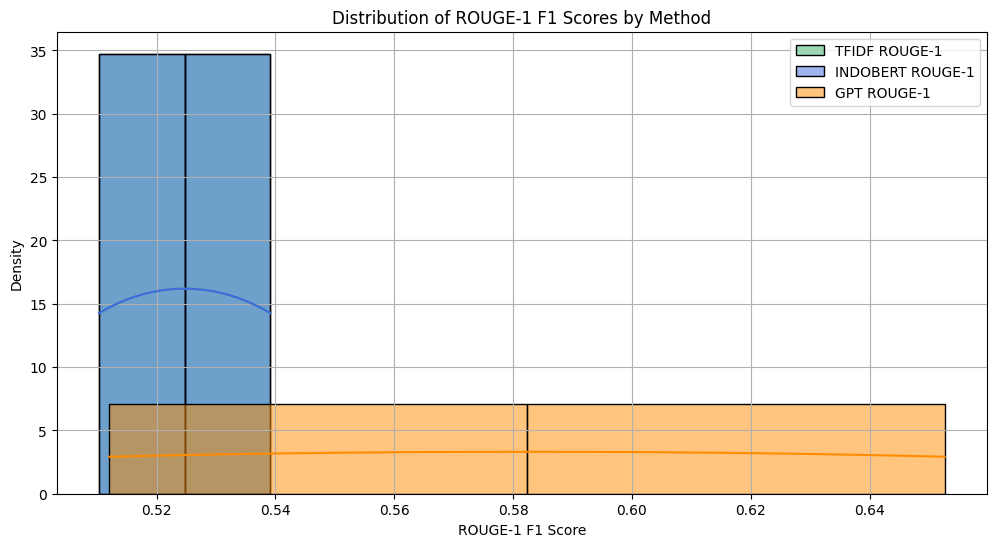

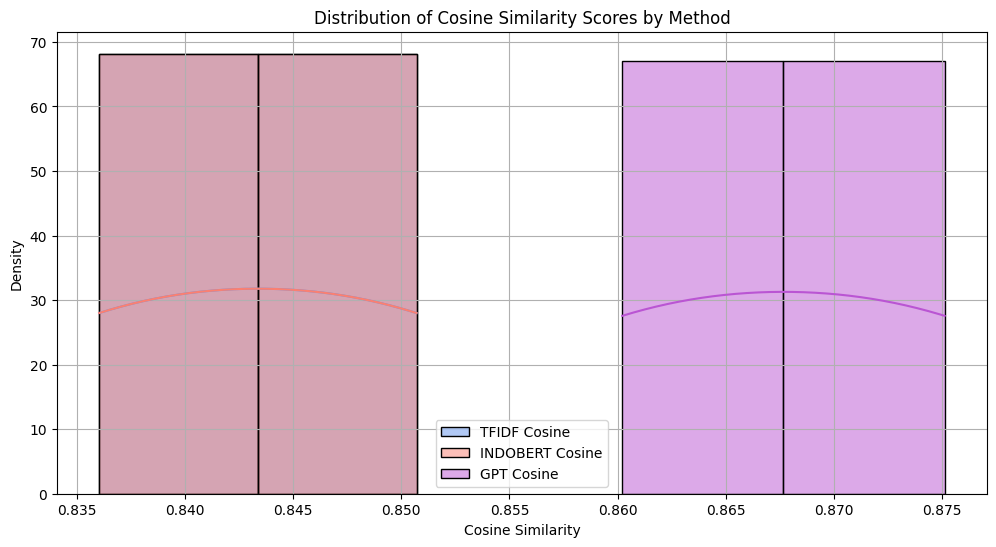

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tampilkan rata-rata ROUGE dan Cosine Similarity untuk setiap metode
methods = ['tfidf', 'indobert', 'gpt']

print("\n--- Average Evaluation Scores by Method ---")
for method in methods:
    print(f"\nMethod: {method.upper()}")
    print(f"Average ROUGE-1 F1: {eval_df[f'{method}_rouge1'].mean():.4f}")
    print(f"Average ROUGE-2 F1: {eval_df[f'{method}_rouge2'].mean():.4f}")
    print(f"Average ROUGE-L F1: {eval_df[f'{method}_rougeL'].mean():.4f}")
    print(f"Average Cosine Similarity: {eval_df[f'{method}_cosine'].mean():.4f}")

# Plot distribusi ROUGE-1 F1 untuk semua metode
plt.figure(figsize=(12, 6))
for method, color in zip(methods, ['mediumseagreen', 'royalblue', 'darkorange']):
    sns.histplot(eval_df[f'{method}_rouge1'], kde=True, stat='density', label=f'{method.upper()} ROUGE-1', color=color)
plt.title('Distribution of ROUGE-1 F1 Scores by Method')
plt.xlabel('ROUGE-1 F1 Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Plot distribusi Cosine Similarity untuk semua metode
plt.figure(figsize=(12, 6))
for method, color in zip(methods, ['cornflowerblue', 'salmon', 'mediumorchid']):
    sns.histplot(eval_df[f'{method}_cosine'], kde=True, stat='density', label=f'{method.upper()} Cosine', color=color)
plt.title('Distribution of Cosine Similarity Scores by Method')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


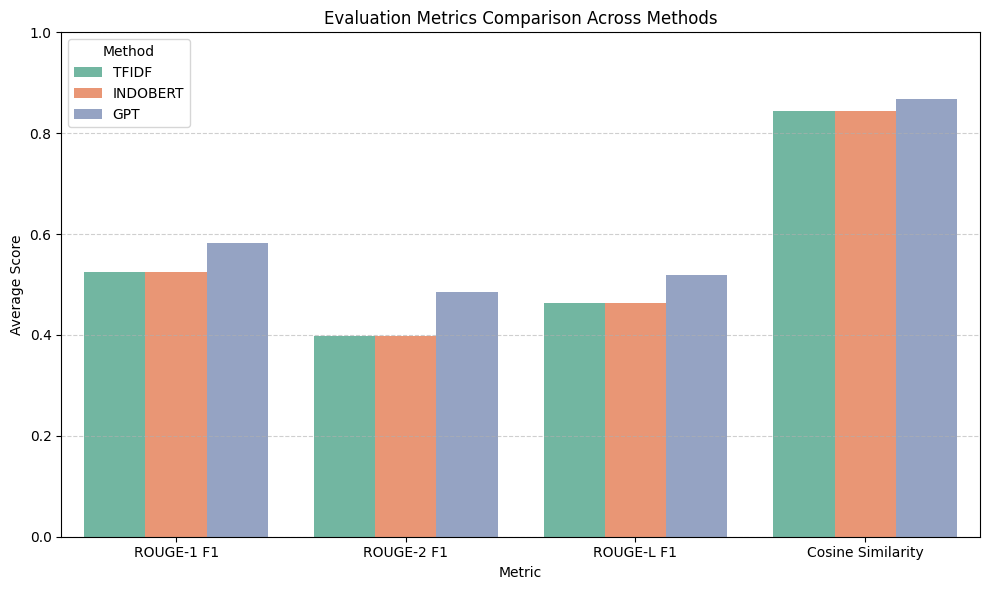

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data evaluasi
data = {
    'Method': ['TFIDF', 'INDOBERT', 'GPT'],
    'ROUGE-1 F1': [0.5247, 0.5247, 0.5823],
    'ROUGE-2 F1': [0.3984, 0.3984, 0.4852],
    'ROUGE-L F1': [0.4627, 0.4627, 0.5183],
    'Cosine Similarity': [0.8434, 0.8434, 0.8677]
}

# Konversi ke DataFrame
df_scores = pd.DataFrame(data)

# Ubah ke format long (melt) untuk memudahkan visualisasi
df_melted = df_scores.melt(id_vars='Method', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Method', palette='Set2')
plt.title('Evaluation Metrics Comparison Across Methods')
plt.ylabel('Average Score')
plt.ylim(0, 1.0)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Method')
plt.tight_layout()
plt.show()
